# Fashion MNIST Data Science Challenge: Neural Networks and Deep Learning


This file contains the code as well as the explanations to our final model.

## Imports

In [1]:
#basic packages
import typing
import math  # needed by keras
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

np.random.RandomState(12345)  # Set random state for constant results
tf.random.set_seed(12345)

In [2]:
# When true explanatory graphs and tensorboard are rendered -> impacts runtime
SHOW_EXPLANATORY_GRAPHS = True

In [3]:
# Clean up data set cache
CACHE_DIR = "cache"
VALIDATION_CACHE_FILE = os.path.join(CACHE_DIR, "validation_data_cache.tfcache")
TRAINING_CACHE_FILE = os.path.join(CACHE_DIR, "training_data_cache.tfcache")

if os.path.isdir(CACHE_DIR):
    # delete dir
    shutil.rmtree(CACHE_DIR)

os.mkdir(CACHE_DIR)

if os.path.isfile(VALIDATION_CACHE_FILE):
    os.remove(VALIDATION_CACHE_FILE)
if os.path.isfile(TRAINING_CACHE_FILE):
    os.remove(TRAINING_CACHE_FILE)

## Data Preparation and Augmentation

  <span style="color:red">*TODO BEWEISE + Methoden*</span>.

### Random erasing
We are using a third-party github repository that implements random_erasing. You can find it [here](https://github.com/yu4u/cutout-random-erasing).

In [4]:
# Import random eraser from its python file
%run random_eraser/random_eraser

### Image rotation and flipping

In [5]:
#Image rotation was used for data augmentation. The function names are self-explanatory
def flip_image_vertical(image: np.ndarray) -> np.ndarray:      
    return np.flip(image, axis=1)

def flip_image_horizontal(image: np.ndarray) -> np.ndarray:
    return np.flip(image, axis=0)

def rotate_270(image: np.ndarray) -> np.ndarray:
    return np.rot90(image, -1)

def rotate_90(image: np.ndarray) -> np.ndarray:
    return np.rot90(image, 1)

In [6]:
def augment_images(input_data: np.ndarray)->typing.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    flipped_images_vertical = np.empty(shape=input_data.shape)
    flipped_images_horizontal = np.empty(shape=input_data.shape)
    rot_images_90 = np.empty(shape=input_data.shape)
    rot_images_270 = np.empty(shape=input_data.shape)
    
    for ind, im in enumerate(input_data):
        flipped_images_vertical[ind] = flip_image_vertical(im)
        flipped_images_horizontal[ind] = flip_image_horizontal(im)
        rot_images_90[ind] = rotate_90(im)
        rot_images_270[ind] = rotate_270(im)
        
    return flipped_images_vertical, flipped_images_horizontal, rot_images_90, rot_images_270

In [7]:
# About 50% Chance that any augmentation happens
ROTATION_CHANCE = 0.1
FLIP_CHANCE = 0.2 # actually 0.1 since tf.image.random_flip_left_right has 0.5 chance
CONSTRAST_CHANCE = 0.2 # actually 0.1 since tf.image.random_contrast has 0.5 chance
BRIGHTNESS_CHANCE = 0.2 # actually 0.1 since tf.image.random_brightness has 0.5 chance
ERASER_CHANCE = 0.25

In [8]:
# function that takes an image as input and creates a randomly augmented image as output
def dataset_aumentation(image: tf.Tensor)->np.ndarray:

    output_image = image
            
    ######## ERASER ########
    # Uses ndim so convert to numpy array
    # Does not work yet
    output_image =  get_random_eraser(p=ERASER_CHANCE, s_l=0.04, s_h=0.2, v_l=-1, v_h=1, pixel_level=True)(output_image)
    
    ######## ROTATE ########
    augmentation_chance = np.random.random_sample(size=None)
    rotation_amount = np.random.randint(0, high=4)
    if (augmentation_chance <= ROTATION_CHANCE):
        # rotation_amount to degrees:
        # 0 = 0°
        # 1 = 90°
        # 2 = 180°
        # 3 = 270°
        # 4 (not possible) = 360° = 0°
        output_image = tf.image.rot90(output_image, k=rotation_amount)
    
    ######## FLIP ########
    augmentation_chance = np.random.random_sample(size=None)
    if (augmentation_chance <= FLIP_CHANCE):
        output_image = tf.image.random_flip_left_right(output_image, seed=12345)
        
    ######## CONTRAST ########
    augmentation_chance = np.random.random_sample(size=None)
    if (augmentation_chance <= CONSTRAST_CHANCE):
        output_image = tf.image.random_contrast(output_image, 0.2, 0.5, seed=12345) 
        
    ######## BRIGHTNESS ########
    augmentation_chance = np.random.random_sample(size=None)
    if (augmentation_chance <= BRIGHTNESS_CHANCE):
        output_image = tf.image.random_brightness(output_image, 0.2, seed=12345) 
        
    return output_image

In [9]:
# Using this as a reference: https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
# Create a call for data set augmentation every epoch
class AugmentationSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentation_func:typing.Callable=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentation_func = augmentation_func
        self.augment_batches = augmentation_func is not None

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        if self.augment_batches:
            return np.array([self.augmentation_func(tensor) for tensor in batch_x]), np.array(batch_y)
        else:
            return np.array(batch_x), np.array(batch_y)

### Data Preparation

In [10]:
#1. Get the file
data_train = pd.read_csv('train.csv')
data_validate = pd.read_csv('test.csv')
data_train = np.array(data_train, dtype = 'float32') # Damit Input Daten von Keras akzeptiert werden müssen wir sie in ein Array umwandeln 
data_validate = np.array(data_validate, dtype='float32') 

In [11]:
# Since we are using a Normalization layer and a Dataset, the preprocessing is only 
# reshaping the arrays and splitting the sets
x_train = data_train[:,1:]
y_train = data_train[:,0] #label data

data_submission = data_validate

In [12]:
#reshape the array containing the images (28px x 28px and 1 channel)
image_rows = 28
image_cols = 28
image_shape = (image_rows,image_cols,1)# 1 da schwarz weiß, bei Farbbildern 3 (r,g,b)

x_train = x_train.reshape(x_train.shape[0],*image_shape)
data_submission = data_submission.reshape(data_submission.shape[0],*image_shape)

In [13]:
#split train data in train and validation set
x_train2,x_validate2,y_train2,y_validate2 = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)

## Modeling

### Parameters

Mostly we decided our parameters by doing hyperparameter tuning via trial and error.

In [14]:
#@felix dein code hier
NUM_EPOCHS = 200
INIT_LR = 1e-3
BATCH_SIZE = 128
L2_PENALTY = 0.003

#### Optimizer
There are multiple articles mentioning SGD as the best optimizer in the long term.
[This article](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/) compares the Adam and SGD optimizer and concludes that SGD with momentum and Nesterov results in a better validation accuracy.
Other articles suggest that even though Adam is faster in the beginning but SGD has better convergence in the long run.

Even though SGD might take more epochs to train, the network's accuracy ends up to be more stable.

In [15]:
our_optimizer = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR/max(NUM_EPOCHS, 1))  # max to prevent divide by 0

#### Loss Function
  <span style="color:red">*Explanation*</span>.
  The aim of this chapter is to evaluate the best loss function on an architecture. We do this by taking a subset of the training. Then we train our models with the different loss functions. Note that all loss functions are trained with the same data. After the training we evaluate the accuracy with: 1. training sample and 2. validation sample for our loss functions. To ensure that we are statistically correct we repeat this `n_survey` times. We aggregate by taking the mean of all  `n_survey` as well as the variance.

In [16]:
# set random seed for dropouts
#tf.random.set_seed(53124)  TODO wird schon oben gemacht

# set params and seed to reproduce code
# np.random.seed(12498)  TODO wird schon oben gemacht
if SHOW_EXPLANATORY_GRAPHS:
    n_epoch = 4
    n_survey = 6
    n_models = 3
    cnt = 0
    # initialize accuracy and its variance
    acc = np.zeros((n_epoch,n_models))
    acc_sq = np.zeros((n_epoch,n_models))
    # initialize validation accuracy and its variance
    vacc = np.zeros((n_epoch,n_models))
    vacc_sq = np.zeros((n_epoch,n_models))

    for ii in np.random.randint(1,100000,n_survey):
        # split rain data in train and validation set, use different random states
        x_tr,x_val,y_tr,y_val = train_test_split(x_train2,y_train2,test_size = 0.2,random_state = ii)
        # update count
        print('__________ ',np.round(cnt/n_survey *100),'% __________')
        cnt += 1


        # iterate through different models
        for jj in range(n_models):
            if jj==0:
                ## sparse categorical crossentropy
                # simple baseline model (to beat)
                msimple = Sequential([
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(.3),
                    Dense(128, activation='relu'),
                    Dropout(.3),
                    Dense(10,activation='softmax')
                ])

                # compile model
                msimple.compile(optimizer='adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

                # train model
                wsimple = msimple.fit(x_tr,y_tr,epochs=n_epoch,verbose=0,
                                      batch_size=64,
                                      validation_data=(x_val,y_val))

                print('\n sparse categorical crossentropy: ',end='')


            elif jj==1:
                ## categorical crossentropy
                # simple baseline model (to beat)
                msimple = Sequential([
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(.3),
                    Dense(128, activation='relu'),
                    Dropout(.3),
                    Dense(10,activation='softmax')
                ])

                # compile model
                msimple.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

                # train model
                wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                                      batch_size=64,
                                      validation_data=(x_val,to_categorical(y_val)))

                print('\n categorical crossentropy: ', end='')


            elif jj==2:
                ## categorical hinge
                # simple baseline model (to beat)
                msimple = Sequential([
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(.3),
                    Dense(128, activation='relu'),
                    Dropout(.3),
                    Dense(10,activation='softmax')
                ])

                # compile model
                msimple.compile(optimizer='adam',
                                loss='categorical_hinge',
                                metrics=['accuracy'])

                # train model
                wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                                      batch_size=64,
                                      validation_data=(x_val,to_categorical(y_val)))

                print('\n categorical hinge: ',end='')

            # save model acc
            tmp1 = wsimple.history['accuracy']
            acc[:,jj] += np.copy(tmp1) /n_survey
            acc_sq[:,jj] += np.copy(tmp1)**2 /n_survey
            tmp2 = wsimple.history['val_accuracy']
            vacc[:,jj] += np.copy(tmp2) /n_survey
            vacc_sq[:,jj] += np.copy(tmp2)**2 /n_survey
            print('acc ',np.round(np.max(tmp1),4),', val acc: ',np.round(np.max(tmp2),4))
    

__________  0.0 % __________

 sparse categorical crossentropy: acc  0.8905 , val acc:  0.8919


KeyboardInterrupt: 

In [17]:
if SHOW_EXPLANATORY_GRAPHS:
    acc_std_err = (acc_sq - acc**2)**.5
    vacc_std_err = (vacc_sq - vacc**2)**.5
    models=['sparse categorical crossentropy','categorical crossentropy',
           'categorical hinge']
    mcolor = ['r','b','y']

    fig = plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    plt.title('training accuracy')
    for jj in range(n_models):
        plt.plot(np.arange(1,5),acc[:,jj],mcolor[jj]+'-', label=models[jj]);
        plt.plot(np.arange(1,5),acc[:,jj]+acc_std_err[:,jj],mcolor[jj]+'o');
        plt.plot(np.arange(1,5),acc[:,jj]-acc_std_err[:,jj],mcolor[jj]+'o');
        plt.legend(loc='lower right');
        plt.xlabel('number of epochs');

    plt.subplot(1,2,2)
    plt.title('validation accuracy')
    for jj in range(n_models):
        plt.plot(np.arange(1,5),vacc[:,jj],mcolor[jj]+'-', label=models[jj]);
        plt.plot(np.arange(1,5),vacc[:,jj]+vacc_std_err[:,jj],mcolor[jj]+'o');
        plt.plot(np.arange(1,5),vacc[:,jj]-vacc_std_err[:,jj],mcolor[jj]+'o');
        plt.legend(loc='lower right');
        plt.xlabel('number of epochs');

Solid lines in the plots indicate the mean over `n_survey` (=6) rounds. The dots are the standard errors. We conclude, that the `categorical_entropy` and `sparse_categorical_crossentropy` are the loss functions we want to consider further. As it turned out, the loss function below it the best for our advanced model. 

In [17]:
our_loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#### Activation Functions
  <span style="color:red">*Explanation*</span>.

In [18]:
model = Sequential([
        # Normalize values from [0,255) to [-1, 1)
        Normalization(input_shape=x_train.shape[1:]),
    
        #3 convolutional layers followed by a max pooling layer
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        #next 3 convolutional layers followed by max pooling layer
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        #3 dense layers followed by output layer
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        Dropout(0.25),

        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)       

## Kompilieren des Modells

In [20]:
model.compile(optimizer = our_optimizer,
                  loss= our_loss_function,
                  metrics = ['accuracy'])

## Training

In [22]:
training_dataset = AugmentationSequence(x_train2, y_train2, BATCH_SIZE, dataset_aumentation)
validation_dataset = AugmentationSequence(x_validate2, y_validate2, BATCH_SIZE)

In [23]:
history = model.fit(
    training_dataset,
    epochs=NUM_EPOCHS,
    #steps_per_epoch=len(x_train2)/ BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset,
    #validation_steps=len(x_validate2)/ BATCH_SIZE,
    )

375/375 [==============================] - 88s 222ms/step - loss: 5.5190 - accuracy: 0.3384 - val_loss: 4.1711 - val_accuracy: 0.7608


In [24]:
# Saving the model 
model.save("trained_models/model_{}".format(datetime.datetime.now().strftime("%d%m%Y_%H%M%S")))

INFO:tensorflow:Assets written to: trained_models/model_04062021_185854\assets


## Prediction

We use a custom algorithm for image prediction.
### Grid Search
When predicting, the image is augmented in multiple ways before forwaring it to the model. Each of these augmented images is evaluated by the model. Afterwards the mean of the resulting categories is calculated and used as actual prediction.

### Impact
This method results in a more stable prediction.  <span style="color:red">*TODO BEWEISE + Mehr schreiben*</span>.

In [25]:
def predict(input_data: np.ndarray) -> np.ndarray:
    assert(input_data[0].shape == (28,28,1))
    augmentedResults = []
    
    augmentedResults.append(model.predict(input_data))
    
    flipped_images_vertical, flipped_images_horizontal, rot_images_90, rot_images_270 = augment_images(input_data)     
    augmentedResults.append(model.predict(flipped_images_vertical))
    augmentedResults.append(model.predict(flipped_images_horizontal))
    augmentedResults.append(model.predict(rot_images_90))
    augmentedResults.append(model.predict(rot_images_270))
    
    return (np.sum(augmentedResults, axis=0) / len(augmentedResults))

# Returns the accuracy
def evaluate(input_data: np.ndarray, input_labels: np.ndarray) -> float:
    assert(len(input_data) == len(input_labels))
    prediction = predict(input_data)
    prediction = np.argmax(prediction, axis = 1)
    
    return np.count_nonzero(prediction == input_labels) / len(input_labels)

## Visualization

In [26]:
score_non_grid = model.evaluate(x_validate2,y_validate2,verbose=0)
score_grid = evaluate(x_validate2,y_validate2)
print('Test Accuracy without grid: {:.4f}'.format(score_non_grid[1]))
print('Test Accuracy with grid: {:.4f}'.format(score_grid))

Test Accuracy without grid: 0.7608
Test Accuracy with grid: 0.7468


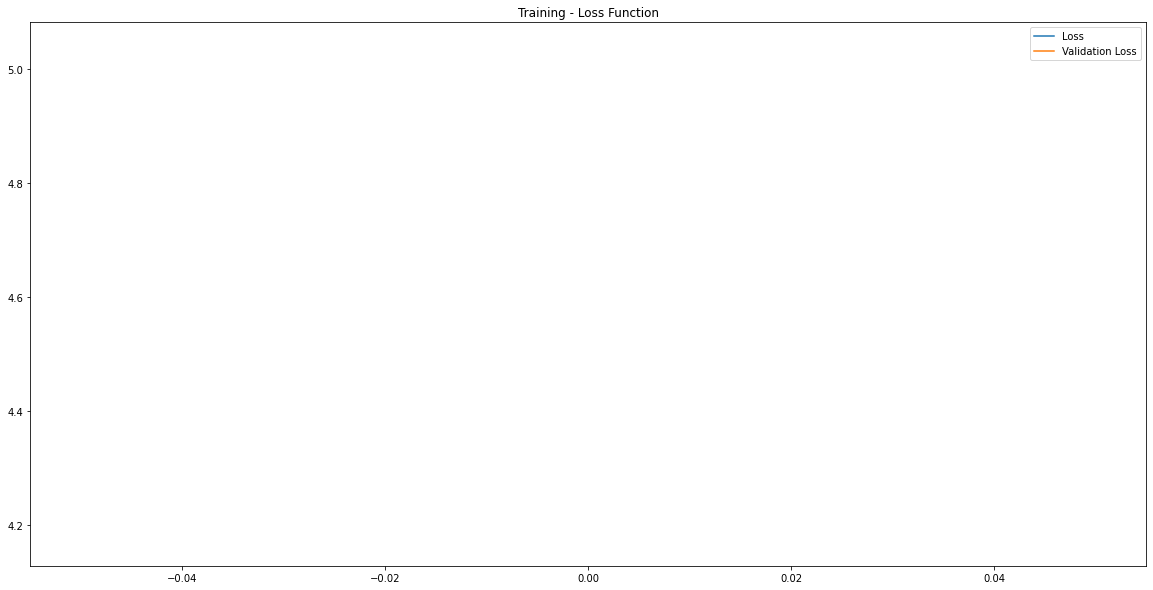

In [27]:
if SHOW_EXPLANATORY_GRAPHS:
    # Training Loss
    plt.figure(figsize=(20, 10))

    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

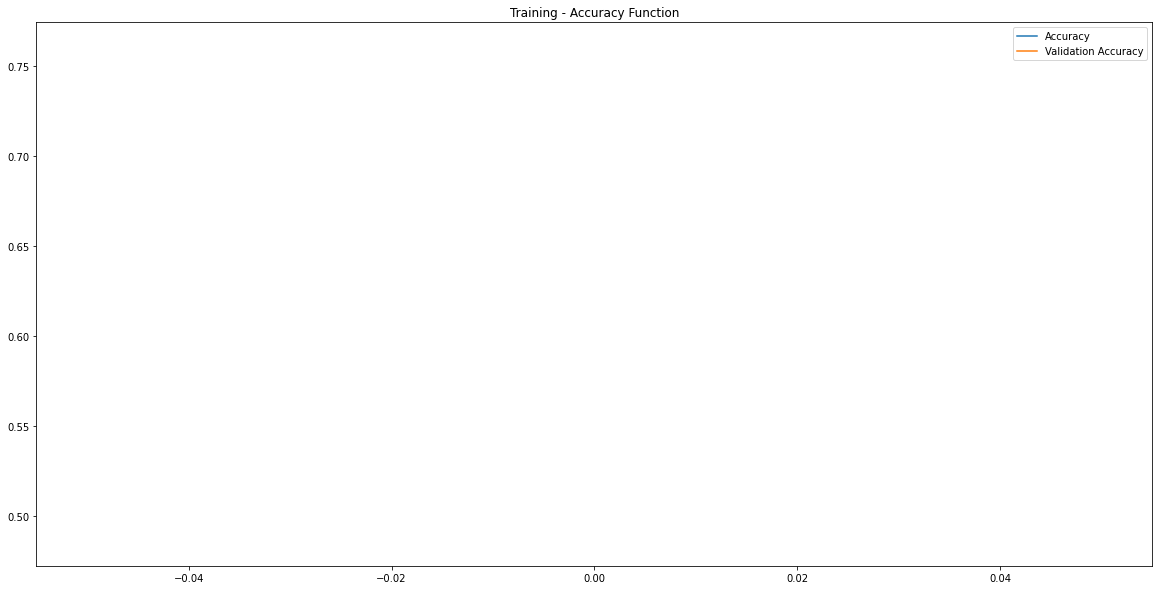

In [28]:
if SHOW_EXPLANATORY_GRAPHS:
    # Training Accuracy
    plt.figure(figsize=(20, 10))

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training - Accuracy Function')

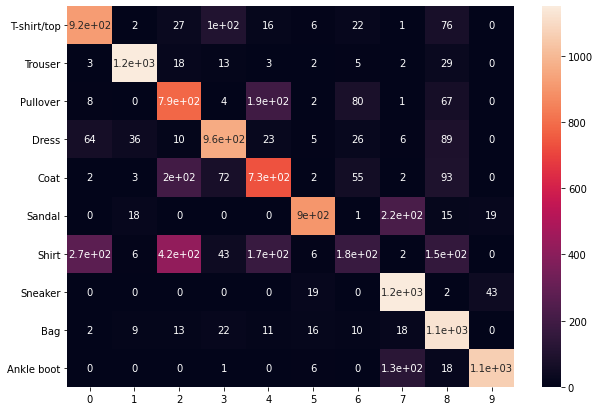

In [29]:
if SHOW_EXPLANATORY_GRAPHS:
    # Confusion matrix with grid
    val_pred = np.argmax(predict(x_validate2), axis = 1)

    conf_matrix = pd.DataFrame(confusion_matrix(y_validate2, val_pred), index=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker","Bag", "Ankle boot"])
    plt.figure(figsize = (10,7))
    sns.heatmap(conf_matrix, annot=True)

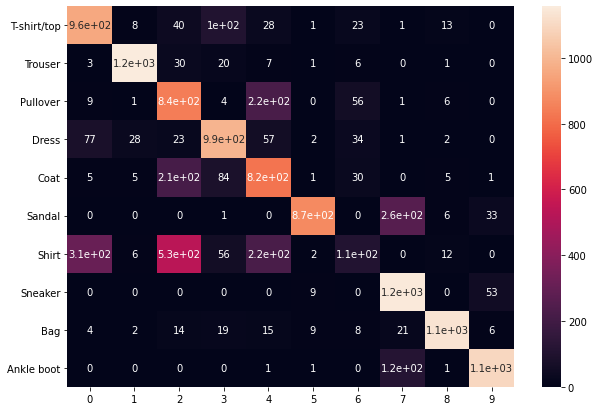

In [30]:
if SHOW_EXPLANATORY_GRAPHS:
    # Confusion matrix without grid
    val_pred = np.argmax(model.predict(x_validate2), axis = 1)

    conf_matrix = pd.DataFrame(confusion_matrix(y_validate2, val_pred), index=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker","Bag", "Ankle boot"])
    plt.figure(figsize = (10,7))
    sns.heatmap(conf_matrix, annot=True)

## Submission

In [31]:
# predict results
results = model.predict(data_submission)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
data_results = pd.DataFrame(results)
data_results.to_csv('fashion_mnist_pred_team1.csv', index=False)#Bitte statt X eure Gruppennummer einfügen! 

## Our Learnings
In the following part we reflect on our network and mention multiple points that could be improved for better classification performance.

### Parameters
Currently the hyperparameter tuning is done manually, but there are libraries (Like [this one](https://keras-team.github.io/keras-tuner/)) that implement systematic hyperparameter tuning. Since this process takes long and is very expensive (each setting needs to be tested after each other), and we (sadly) do not have the computational power to execute the process, we decided against using it. 


### Network Structure
In order to keep the computational complexity as low as possible we decided to use a more shallow structure.
Even though it performs very well research as well as the [official zalando github](https://github.com/zalandoresearch/fashion-mnist) suggest that a deeper network topography contributes to a more accurate classificaion. One of the inspirations for our network structure ([article here](https://medium.com/@mjbhobe/classifying-fashion-with-a-keras-cnn-achieving-94-accuracy-part-3-c7ca2919232b)) also mentions the benefits of a deeper network.

Additionally other structures like DenseNet (described in [this paper](https://arxiv.org/abs/1608.06993)) or ResNet variations can be used to boost accuracy. Tensorflow offers a wide range of pretrained models that can be easily used ([list here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)).

Also using cross validation (as described [here](https://towardsdatascience.com/3-methods-to-reduce-overfitting-of-machine-learning-models-4a7e2c1da9ef) and [here](https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/)) can help with minimizing overfitting, but it is computationally rather expensive since multiple models have to be trained.

### Data Preprocessing
While we used rudimentary data preprocessing functions, the model can benefit from a more extensive use of these methods. [This library](https://github.com/mdbloice/Augmentor) implements various image preprocessing functions that are well-suited for this purpose. Nethertheless the currently implemented preprocessor already increased the model's capability of generalization. A downside is that the accuracy fluctautes heavily in the beginning and training takes more epochs.

### Errors
The confusion matrix shows, that the network displays poor classification capabilities on some classes (like dresses and shirts) whereas it has no difficulty categorizing others (i.e. boots and bags). Sadly we were not able to eliminate these shortcomings. The main problem for this is the lack of training data, which cannot fully be overcome by data augmentation. However, as we have mentioned before, we believe that a higher accuracy is only obtainable for much deeper networks. 
Another problem we face is that our model still tends to overfit the training data. We have already tackled this issue by using batch normalisation layers, l2 penalty and dropout without complete success. Surprisingly, we found that increasing measures to overcome overfitting decreased the models overall performance which is why we chose not to tackle overfitting more.